# Feature Engineering

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

***Load datasets***

In [78]:
loans_test = pd.read_csv("./data/cleaned_data/loans_test.csv")
loans_train = pd.read_csv("./data/cleaned_data/loans_train.csv")
loans_valid = pd.read_csv("./data/cleaned_data/loans_valid.csv")

loans_test.drop(columns=["LoanID"], inplace=True)
loans_valid.drop(columns=["LoanID"], inplace=True)
loans_train.drop(columns=["LoanID"], inplace=True)

In [79]:
loans_train.columns.tolist()

['0_CurrentActualUPB',
 '0_CurrentInterestRate',
 '0_CurrentNonInterestBearingUPB',
 '0_EstimatedLTV',
 '0_InterestBearingUPB',
 '0_LoanAge',
 '0_MonthlyReportingPeriod',
 '0_RemainingMonthsToLegalMaturity',
 '1_CurrentActualUPB',
 '1_CurrentInterestRate',
 '1_CurrentNonInterestBearingUPB',
 '1_EstimatedLTV',
 '1_InterestBearingUPB',
 '1_LoanAge',
 '1_MonthlyReportingPeriod',
 '1_RemainingMonthsToLegalMaturity',
 '2_CurrentActualUPB',
 '2_CurrentInterestRate',
 '2_CurrentNonInterestBearingUPB',
 '2_EstimatedLTV',
 '2_InterestBearingUPB',
 '2_LoanAge',
 '2_MonthlyReportingPeriod',
 '2_RemainingMonthsToLegalMaturity',
 '3_CurrentActualUPB',
 '3_CurrentInterestRate',
 '3_CurrentNonInterestBearingUPB',
 '3_EstimatedLTV',
 '3_InterestBearingUPB',
 '3_LoanAge',
 '3_MonthlyReportingPeriod',
 '3_RemainingMonthsToLegalMaturity',
 '4_CurrentActualUPB',
 '4_CurrentInterestRate',
 '4_CurrentNonInterestBearingUPB',
 '4_EstimatedLTV',
 '4_InterestBearingUPB',
 '4_LoanAge',
 '4_MonthlyReportingPeriod

## Process Data

***fillna***

In [80]:

# Step 1. 标记 *静态* 特征的缺失
print("Step 1: 标记 *静态* 特征的缺失...")

# 明确列出那些来自 1_eda.ipynb 且包含 9999/999/9 代码的 *静态* 特征
STATIC_COLS_TO_FLAG = [
    'CreditScore', 'MI_Pct', 'OriginalCLTV', 'OriginalDTI', 'OriginalLTV',
    'FirstTimeHomebuyerFlag', 'OccupancyStatus', 'Channel', 'PropertyType', 
    'LoanPurpose', 'MSA', 'NumberOfUnits'
    # ( ... 仅包含您在 1_eda.ipynb 中发现有特殊缺失代码 的 *静态* 特征)
]

for df in [loans_train, loans_valid, loans_test]:
    for col in STATIC_COLS_TO_FLAG:
        if col in df.columns:
            # 这会创建 "CreditScore_is_missing" = 1 这样的强大信号
            df[f"{col}_is_missing"] = df[col].isna().astype(int)

print(f"   → 已为 {len(STATIC_COLS_TO_FLAG)} 个静态特征创建 _is_missing 标志。")

# Step 2. 用中位数填充 *静态* 特征的数值列
print("Step 2: 用中位数填充 *静态* 特征的原始列...")
static_num_cols_to_fill = [
    'CreditScore', 'MI_Pct', 'OriginalCLTV', 'OriginalDTI', 'OriginalLTV', 'MSA', 'NumberOfUnits'
]
for df in [loans_train, loans_valid, loans_test]:
    # 用中位数填充
    # 注意：动态列 (0_EstimatedLTV 等) 仍然保持 NaN，这是正确的！
    df[static_num_cols_to_fill] = df[static_num_cols_to_fill].fillna(df[static_num_cols_to_fill].median())

print("   → 静态特征填充完成。")

Step 1: 标记 *静态* 特征的缺失...
   → 已为 12 个静态特征创建 _is_missing 标志。
Step 2: 用中位数填充 *静态* 特征的原始列...
   → 静态特征填充完成。


In [81]:
loans_train.columns.tolist()

['0_CurrentActualUPB',
 '0_CurrentInterestRate',
 '0_CurrentNonInterestBearingUPB',
 '0_EstimatedLTV',
 '0_InterestBearingUPB',
 '0_LoanAge',
 '0_MonthlyReportingPeriod',
 '0_RemainingMonthsToLegalMaturity',
 '1_CurrentActualUPB',
 '1_CurrentInterestRate',
 '1_CurrentNonInterestBearingUPB',
 '1_EstimatedLTV',
 '1_InterestBearingUPB',
 '1_LoanAge',
 '1_MonthlyReportingPeriod',
 '1_RemainingMonthsToLegalMaturity',
 '2_CurrentActualUPB',
 '2_CurrentInterestRate',
 '2_CurrentNonInterestBearingUPB',
 '2_EstimatedLTV',
 '2_InterestBearingUPB',
 '2_LoanAge',
 '2_MonthlyReportingPeriod',
 '2_RemainingMonthsToLegalMaturity',
 '3_CurrentActualUPB',
 '3_CurrentInterestRate',
 '3_CurrentNonInterestBearingUPB',
 '3_EstimatedLTV',
 '3_InterestBearingUPB',
 '3_LoanAge',
 '3_MonthlyReportingPeriod',
 '3_RemainingMonthsToLegalMaturity',
 '4_CurrentActualUPB',
 '4_CurrentInterestRate',
 '4_CurrentNonInterestBearingUPB',
 '4_EstimatedLTV',
 '4_InterestBearingUPB',
 '4_LoanAge',
 '4_MonthlyReportingPeriod

***log1p process***

In [82]:
# 选择数值列（去掉 target, index 等）
numeric_cols = loans_train.select_dtypes(include=[np.number]).drop(columns=["target", "index"], errors="ignore")

# 计算偏度（skewness）
skewness = numeric_cols.skew(axis=0, skipna=True)

# 筛选出高偏度列
high_skew_cols = skewness[abs(skewness) > 1].sort_values(ascending=False)
print("📊 高偏度数值列 (|skew| > 1):")
print(high_skew_cols.to_string())


📊 高偏度数值列 (|skew| > 1):
OriginalDTI_is_missing               174.653944
CreditScore_is_missing                61.728235
PropertyType_CP                       18.978436
MaturityMonth                         13.640573
BalloonIndicator_Y                    11.023891
0_LoanAge                             10.056285
1_LoanAge                             10.056285
9_LoanAge                             10.056285
3_LoanAge                             10.056285
8_LoanAge                             10.056285
12_LoanAge                            10.056285
11_LoanAge                            10.056285
6_LoanAge                             10.056285
13_LoanAge                            10.056285
5_LoanAge                             10.056285
10_LoanAge                            10.056285
7_LoanAge                             10.056285
4_LoanAge                             10.056285
2_LoanAge                             10.056285
SuperConformingFlag_Y                  9.487872
NumberOfUnits    

In [83]:
import numpy as np

# ============================================================
# 🧮 Step 1 — 定义需 log1p 的列（金额类连续特征）
# ============================================================
cols_to_log = (
    ["OriginalUPB"]
    + [f"{i}_CurrentActualUPB" for i in range(14)]
    + [f"{i}_InterestBearingUPB" for i in range(14)]
)

# ============================================================
# 📊 Step 2 — 同步处理三张表（不做 clip）
# ============================================================
datasets = {
    "train": loans_train,
    "valid": loans_valid,
    "test": loans_test
}

for name, df in datasets.items():
    transformed = 0
    for col in cols_to_log:
        if col in df.columns:
            df[col] = np.log1p(df[col])
            transformed += 1
    print(f"✅ [{name}] log1p transformed {transformed} columns")

# ============================================================
# 🧾 Step 3 — 打印结果验证
# ============================================================
for name, df in datasets.items():
    print(f"{name:>5} shape: {df.shape}")


✅ [train] log1p transformed 29 columns
✅ [valid] log1p transformed 29 columns
✅ [test] log1p transformed 29 columns
train shape: (30504, 186)
valid shape: (5370, 186)
 test shape: (13426, 185)


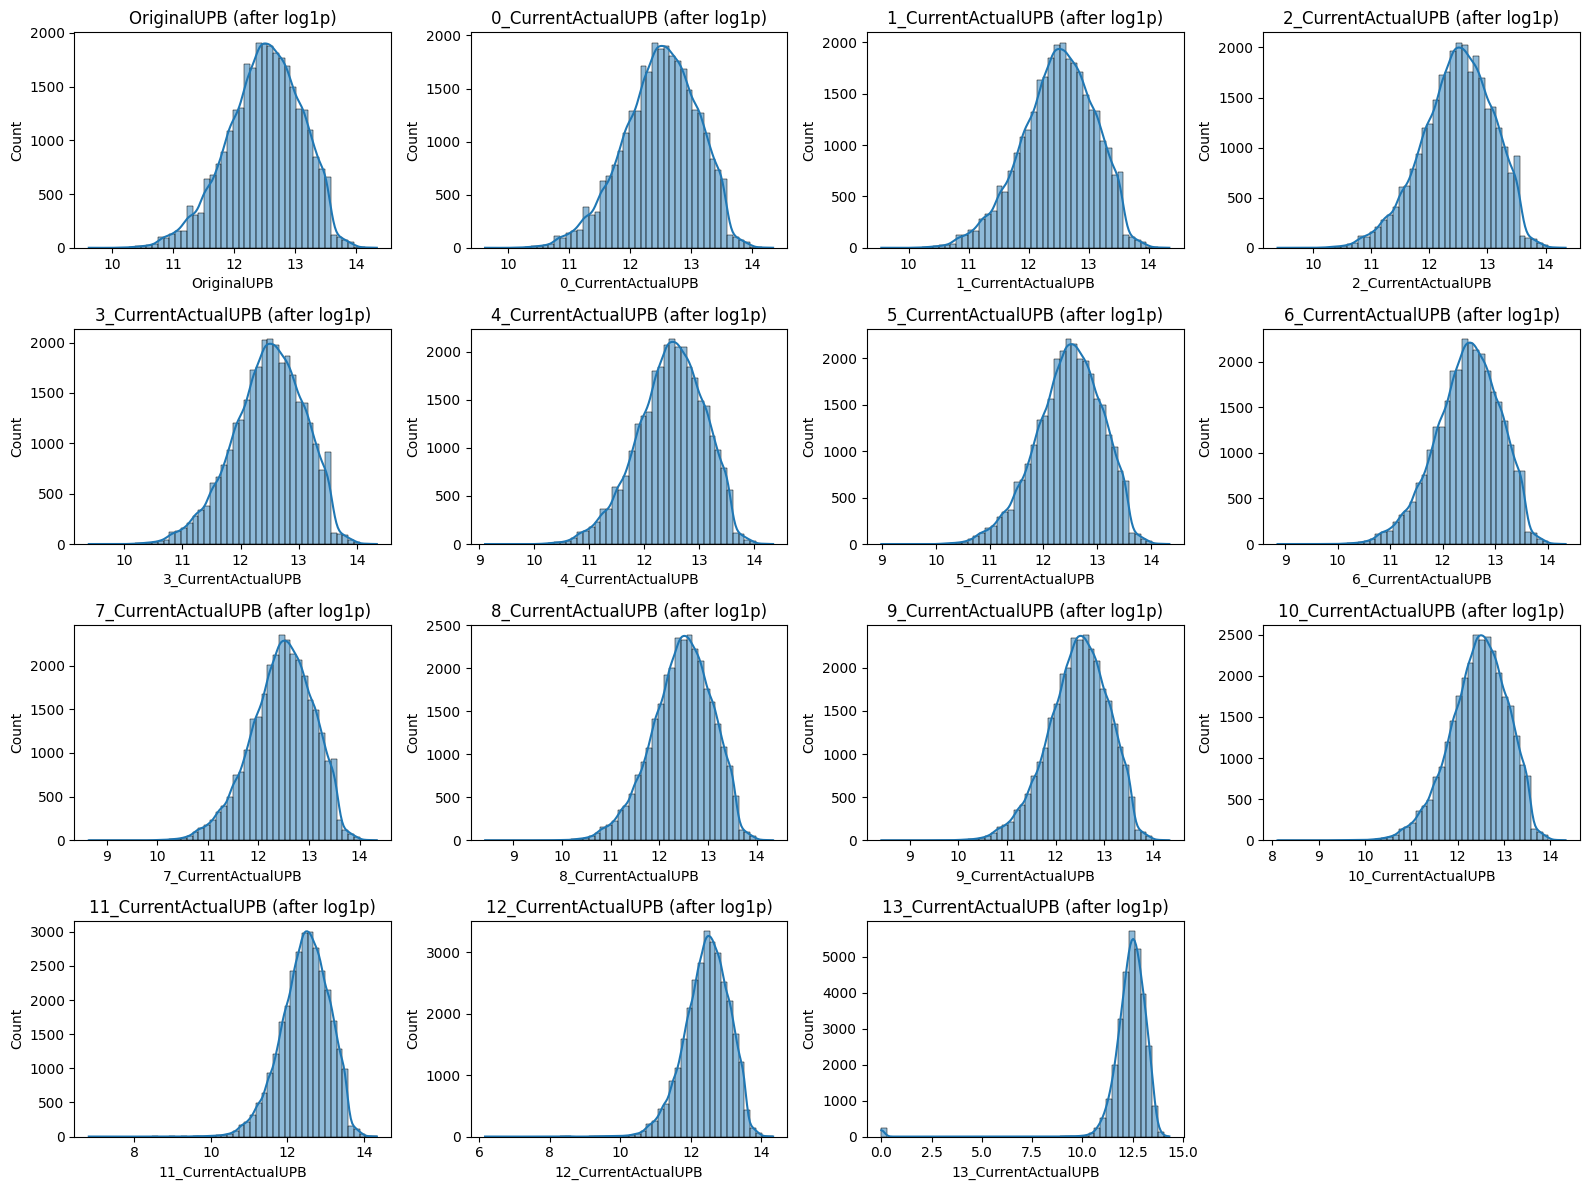

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# 按时间顺序选取所有 UPB 列
cols_plot = ["OriginalUPB"] + [f"{i}_CurrentActualUPB" for i in range(14)]

# 设置画布
plt.figure(figsize=(16, 12))
for i, col in enumerate(cols_plot, 1):
    plt.subplot(4, 4, i)
    sns.histplot(loans_train[col], bins=50, kde=True)
    plt.title(f"{col} (after log1p)")
plt.tight_layout()
plt.show()


## Static Data

In [85]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def static_feature_engineering(df):
    """
    静态特征工程（发放期变量）：
    - 缺失填充：对基础数值列用中位数填补，避免后续计算/建模报错
    - 派生风险特征：DTI比例、CLTV-LTV差、期限比、利息负担、月供近似、信用-杠杆比、每借款人负担、发放-到期年差
    - 月份周期编码：First/Maturity 月份用 sin-cos 编码捕捉周期性
    - 标准化：对选定静态与派生列做标准化，便于线性/距离类模型训练
    """
    df = df.copy()

    # ========= 1️⃣ 原始静态数值列 =========
    base_numeric = [
        "CreditScore", "MSA", "MI_Pct", "NumberOfUnits",
        "OriginalCLTV", "OriginalDTI", "OriginalUPB", "OriginalLTV",
        "OriginalInterestRate", "OriginalLoanTerm", "NumberOfBorrowers",
        "PropertyValMethod", "DesignedLoanTermMonths",
        "FirstPaymentYear", "FirstPaymentMonth",
        "MaturityYear", "MaturityMonth"
    ]

    # 保证存在
    available_cols = [c for c in base_numeric if c in df.columns]
    df[available_cols] = df[available_cols].fillna(df[available_cols].median())

    # ========= 2️⃣ 派生特征 =========
    df["DebtToIncomeRatio"] = df["OriginalDTI"] / 100
    df["LoanToValueGap"] = df["OriginalCLTV"] - df["OriginalLTV"]
    df["LoanTermRatio"] = df["DesignedLoanTermMonths"] / df["OriginalLoanTerm"].replace(0, np.nan)
    df["InterestBurden"] = df["OriginalInterestRate"] * df["OriginalUPB"]
    df["MonthlyPaymentApprox"] = df["OriginalUPB"] * (df["OriginalInterestRate"] / 100) / 12
    df["CreditRiskScore"] = df["CreditScore"] / df["OriginalLTV"].replace(0, np.nan)
    df["BorrowerDensity"] = df["OriginalUPB"] / df["NumberOfBorrowers"].replace(0, np.nan)
    df["LoanTermDiff"] = df["MaturityYear"] - df["FirstPaymentYear"]

    derived_cols = [
        "DebtToIncomeRatio", "LoanToValueGap", "LoanTermRatio",
        "InterestBurden", "MonthlyPaymentApprox",
        "CreditRiskScore", "BorrowerDensity", "LoanTermDiff"
    ]

    # ========= 3️⃣ 月份周期编码 =========
    if "FirstPaymentMonth" in df.columns:
        df["FirstPaymentMonth_sin"] = np.sin(2 * np.pi * df["FirstPaymentMonth"] / 12)
        df["FirstPaymentMonth_cos"] = np.cos(2 * np.pi * df["FirstPaymentMonth"] / 12)
    if "MaturityMonth" in df.columns:
        df["MaturityMonth_sin"] = np.sin(2 * np.pi * df["MaturityMonth"] / 12)
        df["MaturityMonth_cos"] = np.cos(2 * np.pi * df["MaturityMonth"] / 12)

    # 删除原始月份列（防止重复信息）
    df.drop(["FirstPaymentMonth", "MaturityMonth"], axis=1, inplace=True, errors="ignore")

    # ========= 4️⃣ 标准化 =========
    scale_cols = [
        "CreditScore", "MSA", "MI_Pct", "NumberOfUnits",
        "OriginalCLTV", "OriginalDTI", "OriginalUPB", "OriginalLTV",
        "OriginalInterestRate", "OriginalLoanTerm", "NumberOfBorrowers",
        "PropertyValMethod", "DesignedLoanTermMonths",
        "FirstPaymentYear", "MaturityYear",
        "FirstPaymentMonth_sin", "FirstPaymentMonth_cos",
        "MaturityMonth_sin", "MaturityMonth_cos"
    ] + derived_cols

    scaler = StandardScaler()
    existing_cols = [c for c in scale_cols if c in df.columns]
    df[existing_cols] = scaler.fit_transform(df[existing_cols])

    print(f"✅ Static feature engineering complete!")
    print(f"   → 标准化列: {len(existing_cols)}")
    print(f"   → 派生特征列: {len(derived_cols)}")
    print(f"   → 新形状: {df.shape}")
    return df


In [86]:
loans_train = static_feature_engineering(loans_train)
loans_valid = static_feature_engineering(loans_valid)
loans_test  = static_feature_engineering(loans_test)


✅ Static feature engineering complete!
   → 标准化列: 27
   → 派生特征列: 8
   → 新形状: (30504, 196)
✅ Static feature engineering complete!
   → 标准化列: 27
   → 派生特征列: 8
   → 新形状: (5370, 196)
✅ Static feature engineering complete!
   → 标准化列: 27
   → 派生特征列: 8
   → 新形状: (13426, 195)


## Feature -> Panel Data

In [87]:
import numpy as np
import pandas as pd
from scipy import stats

def extract_time_series_features(df, base_variables, time_points=14):
    """
    提取面板时序特征（14期）：
    - 基础统计: mean/std/min/max/range/missing_ratio
    - 差分统计: mean_diff/std_diff；std_of_changes=月度变动稳定性
    - 冲击强度: max_abs_period_change=相邻最大绝对变动
    - 严格一致性: 
      * LoanAge: loanage_consistency(==+1比例), num_inconsistencies(≠+1计数)
      * RemainingMonthsToLegalMaturity: maturity_consistency(==-1比例), num_inconsistencies(≠-1计数)
    - 利率稳定性(仅 CurrentInterestRate): num_rate_levels(唯一值个数), num_rate_changes(变更次数)
    - 交互: LTV_mean_div_CreditScore = EstimatedLTV_mean / CreditScore
    - 趋势与分段: 全局 slope/r2/first/last/diff；early/mid/late 分段 mean/std/slope
    - 变化频次: num_increase/num_decrease/num_sign_flips/max_drop/cum_drop/num_positive(>0月数)
    """

    print(f"📊 Extracting enhanced time series features for {len(base_variables)} variables...")
    result_df = df.copy()
    total_added = 0

    # 时间段切片索引
    segments = {
        "early": range(0, 4),
        "mid": range(4, 10),
        "late": range(10, 14)
    }

    for base_var in base_variables:
        time_cols = [f"{t}_{base_var}" for t in range(time_points)]
        existing_cols = [c for c in time_cols if c in df.columns]
        if not existing_cols:
            continue

        time_data = df[existing_cols].astype(float).values
        n_samples = time_data.shape[0]

        # ===== 基础统计 =====
        result_df[f"{base_var}_mean"] = np.nanmean(time_data, axis=1)
        result_df[f"{base_var}_std"] = np.nanstd(time_data, axis=1)
        result_df[f"{base_var}_min"] = np.nanmin(time_data, axis=1)
        result_df[f"{base_var}_max"] = np.nanmax(time_data, axis=1)
        result_df[f"{base_var}_range"] = result_df[f"{base_var}_max"] - result_df[f"{base_var}_min"]
        result_df[f"{base_var}_missing_ratio"] = np.mean(np.isnan(time_data), axis=1)

        # ===== 差分 =====
        diffs = np.diff(time_data, axis=1)
        result_df[f"{base_var}_mean_diff"] = np.nanmean(diffs, axis=1)
        result_df[f"{base_var}_std_diff"] = np.nanstd(diffs, axis=1)
        # 变化的标准差（与 _std_diff 一致，单独命名便于引用）
        result_df[f"{base_var}_std_of_changes"] = np.nanstd(diffs, axis=1)
        # 最大单期变动（相邻两月绝对差的最大值）
        result_df[f"{base_var}_max_abs_period_change"] = np.nanmax(np.abs(diffs), axis=1)
        
        # ===== 期限/账龄一致性（只对特定变量计算）=====
        valid_pairs = (~np.isnan(time_data[:, :-1])) & (~np.isnan(time_data[:, 1:]))
        denom = valid_pairs.sum(axis=1).clip(min=1)  # 避免除0
        if base_var == 'RemainingMonthsToLegalMaturity':
            eq_neg1 = ((diffs == -1) & valid_pairs).sum(axis=1)
            result_df[f"{base_var}_maturity_consistency"] = eq_neg1 / denom
            # 不一致次数（不等于 -1 的有效相邻对）
            inconsistent = ((diffs != -1) & valid_pairs).sum(axis=1)
            result_df[f"{base_var}_num_inconsistencies"] = inconsistent
        if base_var == 'LoanAge':
            eq_pos1 = ((diffs == 1) & valid_pairs).sum(axis=1)
            result_df[f"{base_var}_loanage_consistency"] = eq_pos1 / denom
            # 不一致次数（不等于 +1 的有效相邻对）
            inconsistent = ((diffs != 1) & valid_pairs).sum(axis=1)
            result_df[f"{base_var}_num_inconsistencies"] = inconsistent

        # ===== 利率稳定性（仅对 CurrentInterestRate）=====
        if base_var == 'CurrentInterestRate':
            num_levels = []
            num_changes = []
            for row in time_data:
                vals = row[~np.isnan(row)]
                if len(vals) == 0:
                    num_levels.append(0)
                    num_changes.append(0)
                else:
                    num_levels.append(len(np.unique(vals)))
                    num_changes.append(int(np.sum(np.diff(vals) != 0)))
            result_df[f"{base_var}_num_rate_levels"] = num_levels
            result_df[f"{base_var}_num_rate_changes"] = num_changes

        # ===== 交互：LTV_mean / CreditScore =====
        if base_var == 'EstimatedLTV' and 'CreditScore' in result_df.columns:
            cs = result_df['CreditScore'].replace(0, np.nan)
            result_df['LTV_mean_div_CreditScore'] = result_df[f'{base_var}_mean'] / (cs + 1e-6)

        # ===== 全局趋势 =====
        slopes, r2, first, last = [], [], [], []
        for row in time_data:
            valid = ~np.isnan(row)
            if np.sum(valid) >= 2:
                y = row[valid]; x = np.arange(len(row))[valid]
                s, _, r, _, _ = stats.linregress(x, y)
                slopes.append(s); r2.append(r**2)
                first.append(y[0]); last.append(y[-1])
            else:
                slopes.append(np.nan); r2.append(np.nan)
                first.append(np.nan); last.append(np.nan)
        result_df[f"{base_var}_slope"] = slopes
        result_df[f"{base_var}_trend_r2"] = r2
        result_df[f"{base_var}_first"] = first
        result_df[f"{base_var}_last"] = last
        result_df[f"{base_var}_diff"] = result_df[f"{base_var}_last"] - result_df[f"{base_var}_first"]

        # ===== 🕒 时段切片统计 =====
        for seg_name, seg_idx in segments.items():
            seg_cols = [f"{t}_{base_var}" for t in seg_idx if f"{t}_{base_var}" in df.columns]
            if not seg_cols: continue
            seg_data = df[seg_cols].astype(float).values
            result_df[f"{base_var}_{seg_name}_mean"] = np.nanmean(seg_data, axis=1)
            result_df[f"{base_var}_{seg_name}_std"] = np.nanstd(seg_data, axis=1)
            # 段内趋势
            seg_slopes = []
            for row in seg_data:
                valid = ~np.isnan(row)
                if np.sum(valid) >= 2:
                    y = row[valid]; x = np.arange(len(row))[valid]
                    s, _, _, _, _ = stats.linregress(x, y)
                    seg_slopes.append(s)
                else:
                    seg_slopes.append(np.nan)
            result_df[f"{base_var}_{seg_name}_slope"] = seg_slopes
        # 前后期差值
        result_df[f"{base_var}_late_minus_early"] = (
            result_df.get(f"{base_var}_late_mean", np.nan) -
            result_df.get(f"{base_var}_early_mean", np.nan)
        )

        # ===== 📈 变化强度与频次 =====
        num_increase, num_decrease, num_sign_flips, max_drop, cum_drop, num_positive, num_missing = [], [], [], [], [], [], []
        for row in time_data:
            # 在移除 NaN 之前，先计算它们
            num_missing.append(np.isnan(row).sum())
            
            valid = ~np.isnan(row)
            row = row[valid]
            if len(row) == 0:
                num_positive.append(0)
                num_increase.append(np.nan)
                num_decrease.append(np.nan)
                num_sign_flips.append(np.nan)
                max_drop.append(np.nan)
                cum_drop.append(np.nan)
                continue
            # 非零（>0）月份计数
            num_positive.append(int(np.sum(row > 0)))
            if len(row) < 2:
                num_increase.append(np.nan)
                num_decrease.append(np.nan)
                num_sign_flips.append(np.nan)
                max_drop.append(np.nan)
                cum_drop.append(np.nan)
                continue
            diff = np.diff(row)
            num_increase.append(np.sum(diff > 0))
            num_decrease.append(np.sum(diff < 0))
            sign_changes = np.sum(np.diff(np.sign(diff)) != 0)
            num_sign_flips.append(sign_changes)
            max_drop.append(np.nanmin(diff))
            cum_drop.append(np.nansum(diff[diff < 0]))
        result_df[f"{base_var}_num_positive"] = num_positive
        result_df[f"{base_var}_num_increase"] = num_increase
        result_df[f"{base_var}_num_decrease"] = num_decrease
        result_df[f"{base_var}_num_sign_flips"] = num_sign_flips
        result_df[f"{base_var}_max_drop"] = max_drop
        result_df[f"{base_var}_cum_drop"] = cum_drop
        result_df[f"{base_var}_num_missing"] = num_missing

        total_added += 30  # approx
        print(f"  ✅ Added extended stats for {base_var} ({total_added} cumulative)")

    # 删除原始时间序列列
    drop_cols = [c for c in df.columns if any(c.startswith(f"{t}_") for t in range(time_points))]
    result_df.drop(columns=drop_cols, inplace=True, errors="ignore")

    print(f"\n🧹 Dropped {len(drop_cols)} original panel columns.")
    print(f"✅ New shape: {result_df.shape}")
    
    # 优化性能：去碎片化 DataFrame
    result_df = result_df.copy()
    return result_df


In [88]:
panel_variables = [
    'CurrentActualUPB',
    'CurrentInterestRate', 
    'CurrentNonInterestBearingUPB',
    'EstimatedLTV',
    'InterestBearingUPB',
    'LoanAge',
    'RemainingMonthsToLegalMaturity'
]

loans_train = extract_time_series_features(loans_train, panel_variables)
loans_valid = extract_time_series_features(loans_valid, panel_variables)
loans_test = extract_time_series_features(loans_test, panel_variables)

📊 Extracting enhanced time series features for 7 variables...


  ✅ Added extended stats for CurrentActualUPB (30 cumulative)
  ✅ Added extended stats for CurrentInterestRate (60 cumulative)


C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_num_missing"] = num_missing
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:41: RuntimeWarning: Mean of empty slice
  result_df[f"{base_var}_mean"] = np.nanmean(time_data, axis=1)
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_mean"] = np.nanmean(time_data, axis=1)
e:\Anaconda\envs\is5126\lib

  ✅ Added extended stats for CurrentNonInterestBearingUPB (90 cumulative)


C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_slope"] = slopes
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_trend_r2"] = r2
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

  ✅ Added extended stats for EstimatedLTV (120 cumulative)


C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_slope"] = slopes
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_trend_r2"] = r2
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

  ✅ Added extended stats for InterestBearingUPB (150 cumulative)


C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_slope"] = slopes
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_trend_r2"] = r2
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

  ✅ Added extended stats for LoanAge (180 cumulative)


C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_slope"] = slopes
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_trend_r2"] = r2
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

  ✅ Added extended stats for RemainingMonthsToLegalMaturity (210 cumulative)

🧹 Dropped 112 original panel columns.
✅ New shape: (30504, 315)
📊 Extracting enhanced time series features for 7 variables...
  ✅ Added extended stats for CurrentActualUPB (30 cumulative)
  ✅ Added extended stats for CurrentInterestRate (60 cumulative)


C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_num_missing"] = num_missing
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:41: RuntimeWarning: Mean of empty slice
  result_df[f"{base_var}_mean"] = np.nanmean(time_data, axis=1)
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_mean"] = np.nanmean(time_data, axis=1)
e:\Anaconda\envs\is5126\lib

  ✅ Added extended stats for CurrentNonInterestBearingUPB (90 cumulative)


C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_slope"] = slopes
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_trend_r2"] = r2
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

  ✅ Added extended stats for EstimatedLTV (120 cumulative)


C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_slope"] = slopes
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_trend_r2"] = r2
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

  ✅ Added extended stats for InterestBearingUPB (150 cumulative)


C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_slope"] = slopes
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_trend_r2"] = r2
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

  ✅ Added extended stats for LoanAge (180 cumulative)


C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_slope"] = slopes
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_trend_r2"] = r2
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

  ✅ Added extended stats for RemainingMonthsToLegalMaturity (210 cumulative)

🧹 Dropped 112 original panel columns.
✅ New shape: (5370, 315)
📊 Extracting enhanced time series features for 7 variables...
  ✅ Added extended stats for CurrentActualUPB (30 cumulative)
  ✅ Added extended stats for CurrentInterestRate (60 cumulative)


C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_num_missing"] = num_missing
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:41: RuntimeWarning: Mean of empty slice
  result_df[f"{base_var}_mean"] = np.nanmean(time_data, axis=1)
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_mean"] = np.nanmean(time_data, axis=1)
e:\Anaconda\envs\is5126\lib

  ✅ Added extended stats for CurrentNonInterestBearingUPB (90 cumulative)


C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_slope"] = slopes
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_trend_r2"] = r2
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

  ✅ Added extended stats for EstimatedLTV (120 cumulative)


C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_slope"] = slopes
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_trend_r2"] = r2
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

  ✅ Added extended stats for InterestBearingUPB (150 cumulative)


C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_slope"] = slopes
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_trend_r2"] = r2
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

  ✅ Added extended stats for LoanAge (180 cumulative)


C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_slope"] = slopes
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_trend_r2"] = r2
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

  ✅ Added extended stats for RemainingMonthsToLegalMaturity (210 cumulative)

🧹 Dropped 112 original panel columns.
✅ New shape: (13426, 314)


C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:167: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_num_positive"] = num_positive
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:168: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f"{base_var}_num_increase"] = num_increase
C:\Users\DELL\AppData\Local\Temp\ipykernel_12372\3073115012.py:169: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

In [89]:
## 数据质量检查

def check_feature_quality(df, dataset_name):
    """
    检查特征工程结果的数据质量
    """
    print(f"=== {dataset_name} 数据质量报告 ===")
    
    # 找到所有时间序列特征
    ts_features = [col for col in df.columns if any(col.endswith(suffix) for suffix in 
                 ['_mean', '_std', '_min', '_max', '_range', '_missing_ratio', '_mean_diff', '_std_diff', '_slope', '_trend_r2', '_first', '_last', '_diff'])]
    
    print(f"时间序列特征数量: {len(ts_features)}")
    
    # 检查NaN值
    nan_features = []
    for feature in ts_features:
        nan_count = df[feature].isna().sum()
        if nan_count > 0:
            nan_features.append((feature, nan_count, nan_count/len(df)*100))
    
    if nan_features:
        print(f"\n⚠️ 发现 {len(nan_features)} 个特征有NaN值:")
        for feature, count, pct in nan_features[:5]:  # 只显示前5个
            print(f"  {feature}: {count} NaN值 ({pct:.1f}%)")
        if len(nan_features) > 5:
            print(f"  ... 还有 {len(nan_features)-5} 个特征有NaN值")
    else:
        print("✅ 所有时间序列特征都没有NaN值")
    
    # 检查EstimatedLTV特征质量
    ltv_features = [col for col in ts_features if 'EstimatedLTV' in col]
    if ltv_features:
        print(f"\n📊 EstimatedLTV特征质量:")
        for feature in ltv_features[:3]:  # 显示前3个
            values = df[feature].dropna()
            if len(values) > 0:
                print(f"  {feature}: 范围[{values.min():.1f}, {values.max():.1f}], 均值{values.mean():.1f}")
    
    print(f"数据集形状: {df.shape}")
    print("-" * 50)

# 检查所有数据集的质量
check_feature_quality(loans_train, "训练集")
check_feature_quality(loans_valid, "验证集") 
check_feature_quality(loans_test, "测试集")


=== 训练集 数据质量报告 ===
时间序列特征数量: 154

⚠️ 发现 21 个特征有NaN值:
  EstimatedLTV_mean: 1690 NaN值 (5.5%)
  EstimatedLTV_std: 1690 NaN值 (5.5%)
  EstimatedLTV_min: 1690 NaN值 (5.5%)
  EstimatedLTV_max: 1690 NaN值 (5.5%)
  EstimatedLTV_range: 1690 NaN值 (5.5%)
  ... 还有 16 个特征有NaN值

📊 EstimatedLTV特征质量:
  EstimatedLTV_mean: 范围[3.1, 166.1], 均值70.6
  EstimatedLTV_std: 范围[0.0, 83.6], 均值3.0
  EstimatedLTV_min: 范围[1.0, 159.0], 均值66.2
数据集形状: (30504, 315)
--------------------------------------------------
=== 验证集 数据质量报告 ===
时间序列特征数量: 154

⚠️ 发现 21 个特征有NaN值:
  EstimatedLTV_mean: 305 NaN值 (5.7%)
  EstimatedLTV_std: 305 NaN值 (5.7%)
  EstimatedLTV_min: 305 NaN值 (5.7%)
  EstimatedLTV_max: 305 NaN值 (5.7%)
  EstimatedLTV_range: 305 NaN值 (5.7%)
  ... 还有 16 个特征有NaN值

📊 EstimatedLTV特征质量:
  EstimatedLTV_mean: 范围[5.0, 161.1], 均值70.6
  EstimatedLTV_std: 范围[0.0, 52.8], 均值3.0
  EstimatedLTV_min: 范围[1.0, 141.0], 均值66.2
数据集形状: (5370, 315)
--------------------------------------------------
=== 测试集 数据质量报告 ===
时间序列特征数量: 154

⚠️ 发现 21

# Feature Selection

# Saving Feature 

In [90]:
loans_train.to_csv("./data/feature_engineering/loans_train.csv")
loans_valid.to_csv("./data/feature_engineering/loans_valid.csv")
loans_test.to_csv("./data/feature_engineering/loans_test.csv")

In [91]:
loans_train.columns.tolist()

['index',
 'target',
 'CreditScore',
 'FirstPaymentDate',
 'FirstTimeHomebuyerFlag',
 'MaturityDate',
 'MSA',
 'MI_Pct',
 'NumberOfUnits',
 'OccupancyStatus',
 'OriginalCLTV',
 'OriginalDTI',
 'OriginalUPB',
 'OriginalLTV',
 'OriginalInterestRate',
 'Channel',
 'PPM_Flag',
 'ProductType',
 'PropertyState',
 'PropertyType',
 'PostalCode',
 'LoanPurpose',
 'OriginalLoanTerm',
 'NumberOfBorrowers',
 'SellerName',
 'ServicerName',
 'SuperConformingFlag',
 'ProgramIndicator',
 'PropertyValMethod',
 'InterestOnlyFlag',
 'BalloonIndicator',
 'FirstTimeHomebuyerFlag_N',
 'FirstTimeHomebuyerFlag_Y',
 'OccupancyStatus_I',
 'OccupancyStatus_P',
 'OccupancyStatus_S',
 'Channel_B',
 'Channel_C',
 'Channel_R',
 'PPM_Flag_N',
 'ProductType_FRM',
 'PropertyType_CO',
 'PropertyType_CP',
 'PropertyType_MH',
 'PropertyType_PU',
 'PropertyType_SF',
 'LoanPurpose_C',
 'LoanPurpose_N',
 'LoanPurpose_P',
 'SuperConformingFlag_Y',
 'ProgramIndicator_9',
 'ProgramIndicator_F',
 'ProgramIndicator_H',
 'Interest